In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression

from doubleml.data import DoubleMLPanelData
from doubleml.did import DoubleMLDIDMulti

In [2]:
import pandas as pd
import numpy as np
dta = pd.read_csv("https://raw.githubusercontent.com/d2cml-ai/csdid/main/data/sim_data.csv")
dta.head()
dta.loc[dta["G"] == 0, "G"] = np.nan

In [3]:
dml_data = DoubleMLPanelData(dta, y_col="Y", d_cols="G", id_col="id", t_col="period", x_cols=["X"])

In [4]:
control_group = "not_yet_treated"
control_group = "never_treated"

ml_g=LinearRegression()
ml_m=LogisticRegression()

# ml_g = LGBMRegressor()
# ml_m = LGBMClassifier()

dml_obj = DoubleMLDIDMulti(
    obj_dml_data=dml_data,
    ml_g=ml_g,
    ml_m=ml_m,
    gt_combinations="standard",
    control_group=control_group,
)

dml_obj.fit()

dml_obj.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
"ATT(2.0,1,2)",0.918577,0.063957,14.362451,0.000000,0.793224,1.043930
"ATT(2.0,1,3)",1.988461,0.064665,30.750246,0.000000,1.861720,2.115201
"ATT(2.0,1,4)",2.954280,0.063294,46.675247,0.000000,2.830225,3.078334
"ATT(3.0,1,2)",-0.042247,0.065929,-0.640793,0.521657,-0.171465,0.086972
"ATT(3.0,2,3)",1.112732,0.065561,16.972543,0.000000,0.984235,1.241228
"ATT(3.0,2,4)",2.059244,0.065484,31.446740,0.000000,1.930898,2.187589
"ATT(4.0,1,2)",0.007441,0.068490,0.108650,0.913480,-0.126796,0.141679
"ATT(4.0,2,3)",0.062091,0.066437,0.934592,0.349999,-0.068122,0.192304
"ATT(4.0,3,4)",0.951063,0.067523,14.084959,0.000000,0.818720,1.083407


In [5]:
level = 0.95

ci = dml_obj.confint(level=level)
dml_obj.bootstrap(n_rep_boot=5000)
ci_joint = dml_obj.confint(level=level, joint=True)

In [6]:
print(dml_obj)

================== DoubleMLDIDMulti Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['G']
Covariates: ['X']
Instrument variable(s): None
Time variable: period
Id variable: id
No. Observations: 3979

------------------ Score & algorithm ------------------
Score function: observational
Control group: never_treated
Anticipation periods: 0

------------------ Machine learner   ------------------
Learner ml_g: LinearRegression()
Learner ml_m: LogisticRegression()
Out-of-sample Performance:
Regression:
Learner ml_g0 RMSE: [[1.42597918 1.40968087 1.40052964 1.42787771 1.40713307 1.42403057
  1.42802689 1.40320538 1.42776935]]
Learner ml_g1 RMSE: [[1.40358956 1.43518576 1.39551046 1.4138002  1.42577686 1.38380243
  1.45865143 1.41456292 1.40745099]]
Classification:
Learner ml_m Log Loss: [[0.69177084 0.69122753 0.6907171  0.67931424 0.68023374 0.67927162
  0.66238847 0.66240294 0.66204557]]

------------------ Resamp

In [8]:
def create_ci_dataframe(dml_obj, level=0.95, joint=True, include_rvs=False):
    """
    Create a DataFrame with coefficient estimates and confidence intervals from a DoubleML object.
    
    Parameters:
    -----------
    dml_obj : DoubleML object
        The fitted DoubleML object
    level : float, default=0.95
        Confidence level for intervals
    joint : bool, default=True
        Whether to use joint confidence intervals
    
    Returns:
    --------
    DataFrame
        DataFrame containing estimates and confidence intervals
    """

    ci = dml_obj.confint(level=level, joint=joint)

    # Create DataFrame
    result_df = pd.DataFrame({
        'First Treated': [gt_combination[0] for gt_combination in dml_obj.gt_combinations],
        'Pre-treatment Period' : [gt_combination[1] for gt_combination in dml_obj.gt_combinations],
        'Evaluation Period': [gt_combination[2] for gt_combination in dml_obj.gt_combinations],
        'Estimate': dml_obj.coef,
        'CI Lower': ci.iloc[:, 0],
        'CI Upper': ci.iloc[:, 1],
        'Pre-Treatment': [gt_combination[2] < gt_combination[0] for gt_combination in dml_obj.gt_combinations],
    })
    if include_rvs:
        result_df["RV"] = dml_obj.sensitivity_params["rv"]
    return result_df

ci_df = create_ci_dataframe(dml_obj, include_rvs=False)
ci_df.head()

,First Treated,Pre-treatment Period,Evaluation Period,Estimate,CI Lower,CI Upper,Pre-Treatment
"ATT(2.0,1,2)",2.0,1,2,0.918577,0.744079,1.093075,False
"ATT(2.0,1,3)",2.0,1,3,1.988461,1.812030,2.164891,False
"ATT(2.0,1,4)",2.0,1,4,2.954280,2.781589,3.126971,False
"ATT(3.0,1,2)",3.0,1,2,-0.042247,-0.222126,0.137632,True
"ATT(3.0,2,3)",3.0,2,3,1.112732,0.933857,1.291606,False


/opt/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/opt/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


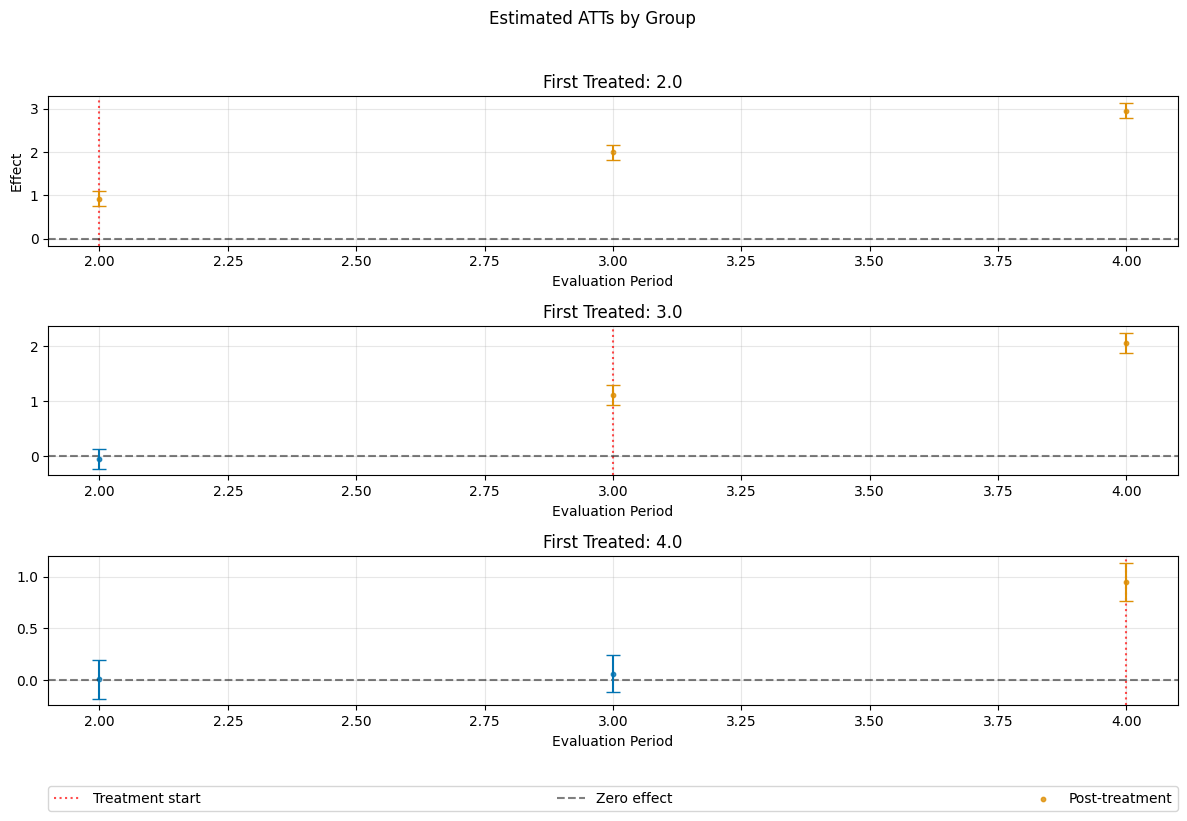

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_atts(dml_obj, level=0.95, joint=True, figsize=(12, 8)):
    """
    Plot coefficient estimates with CIs over time, grouped by first treated period.
    CIs with the same x-value are jittered horizontally for better visibility.
    Works with both numeric and datetime values.
    """
    df = create_ci_dataframe(dml_obj, level=level, joint=joint)
    all_time_periods = sorted(df['Evaluation Period'].unique())
    first_treated_periods = sorted(df['First Treated'].unique())
    n_periods = len(first_treated_periods)
    colors = dict(zip(['pre', 'post'], sns.color_palette("colorblind")[:2]))
    
    # Check if we're dealing with datetime values
    is_datetime = pd.api.types.is_datetime64_any_dtype(df['Evaluation Period'])
    
    # Adjust figure size to accommodate bottom legend
    fig = plt.figure(figsize=figsize)
    # Create subplot grid with space for legend at bottom
    gs = fig.add_gridspec(n_periods + 1, 1, height_ratios=[3]*n_periods + [0.5])
    axes = [fig.add_subplot(gs[i]) for i in range(n_periods)]

    if n_periods == 1:
        axes = [axes]
    
    # Create a list to store legend handles and labels
    legend_elements = []
    
    # Define jitter amount - different handling for datetime vs numeric
    if is_datetime:
        # For datetime, calculate time difference between periods
        if len(all_time_periods) > 1:
            time_diff = (all_time_periods[1] - all_time_periods[0]).total_seconds()
            jitter_seconds = time_diff * 0.1  # Use 5% of time difference for jitter
        else:
            jitter_seconds = 86400 * 0.05  # Default to 5% of a day if only one period
    else:
        jitter_amount = 0.1  # Standard numeric jitter
    
    for idx, period in enumerate(first_treated_periods):
        period_data = df[df['First Treated'] == period]
        ax = axes[idx]

        i_period = all_time_periods.index(period)

        # Add treatment start line
        line = ax.axvline(x=all_time_periods[i_period], color='red', 
                         linestyle=':', alpha=0.7)
        if idx == 0:
            legend_elements.append((line, 'Treatment start'))

        zero_line = ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        if idx == 0:
            legend_elements.append((zero_line, 'Zero effect'))

        # Split data by treatment status
        pre_treatment = period_data[period_data['Pre-Treatment']]
        post_treatment = period_data[~period_data['Pre-Treatment']]
        
        if not pre_treatment.empty:
            pre_treatment = pre_treatment.copy()
            
            for x_val in pre_treatment['Evaluation Period'].unique():
                mask = pre_treatment['Evaluation Period'] == x_val
                count = mask.sum()
                if count > 1:
                    if is_datetime:
                        # For datetime values, create timedelta jitters
                        jitter_range = np.linspace(-jitter_seconds, jitter_seconds, count)
                        jitters = [pd.Timedelta(seconds=float(j)) for j in jitter_range]
                    else:
                        # For numeric values, create standard jitters
                        jitters = np.linspace(-jitter_amount, jitter_amount, count)
                    
                    # Store the jitters for these points
                    pre_treatment.loc[mask, 'jitter_index'] = range(count)
                    for i, j in enumerate(jitters):
                        pre_treatment.loc[mask & (pre_treatment['jitter_index'] == i), 'jittered_x'] = x_val + j
            
            # For points without jitter (single point at x-value)
            if 'jittered_x' not in pre_treatment.columns:
                pre_treatment['jittered_x'] = pre_treatment['Evaluation Period']
            else:
                mask = ~pre_treatment['jittered_x'].notna()
                pre_treatment.loc[mask, 'jittered_x'] = pre_treatment.loc[mask, 'Evaluation Period']
            
            # Pre-treatment points with jitter
            scatter_pre = ax.scatter(pre_treatment['jittered_x'], 
                                   pre_treatment['Estimate'], 
                                   color=colors['pre'], alpha=0.8, s=10)
            
            # Regular CIs with jitter
            error_pre = ax.errorbar(pre_treatment['jittered_x'], 
                                  pre_treatment['Estimate'],
                                  yerr=[pre_treatment['Estimate'] - pre_treatment['CI Lower'],
                                       pre_treatment['CI Upper'] - pre_treatment['Estimate']],
                                  fmt='none', color=colors['pre'], alpha=1.0, 
                                  capsize=5)
            if idx == 0:
                legend_elements.extend([
                    (scatter_pre, 'Pre-treatment'),
                    (error_pre, f'{int(level*100)}% CI'),
                ])
        
        # Similar structure for post-treatment with jittering
        if not post_treatment.empty:
            post_treatment = post_treatment.copy()
            
            for x_val in post_treatment['Evaluation Period'].unique():
                mask = post_treatment['Evaluation Period'] == x_val
                count = mask.sum()
                if count > 1:
                    if is_datetime:
                        # For datetime values, create timedelta jitters
                        jitter_range = np.linspace(-jitter_seconds, jitter_seconds, count)
                        jitters = [pd.Timedelta(seconds=float(j)) for j in jitter_range]
                    else:
                        # For numeric values, create standard jitters
                        jitters = np.linspace(-jitter_amount, jitter_amount, count)
                    
                    # Store the jitters for these points
                    post_treatment.loc[mask, 'jitter_index'] = range(count)
                    for i, j in enumerate(jitters):
                        post_treatment.loc[mask & (post_treatment['jitter_index'] == i), 'jittered_x'] = x_val + j
            
            # For points without jitter (single point at x-value)
            if 'jittered_x' not in post_treatment.columns:
                post_treatment['jittered_x'] = post_treatment['Evaluation Period']
            else:
                mask = ~post_treatment['jittered_x'].notna()
                post_treatment.loc[mask, 'jittered_x'] = post_treatment.loc[mask, 'Evaluation Period']
            
            scatter_post = ax.scatter(post_treatment['jittered_x'], 
                                    post_treatment['Estimate'], 
                                    color=colors['post'], alpha=0.8, s=10)
            if idx == 0:
                legend_elements.append((scatter_post, 'Post-treatment'))
            
            # Error bars with jitter
            ax.errorbar(post_treatment['jittered_x'], post_treatment['Estimate'],
                       yerr=[post_treatment['Estimate'] - post_treatment['CI Lower'],
                             post_treatment['CI Upper'] - post_treatment['Estimate']],
                       fmt='none', color=colors['post'], alpha=1.0, capsize=5)

        ax.set_title(f'First Treated: {period}')
        ax.grid(True, alpha=0.3)
        
        if idx == 0:
            ax.set_ylabel('Effect')
        ax.set_xlabel('Evaluation Period')
    
    # Create legend in a separate subplot at the bottom
    legend_ax = fig.add_subplot(gs[-1])
    legend_ax.axis('off')  # Hide axes for legend subplot
    
    # Add legend using collected handles and labels
    legend = legend_ax.legend(*zip(*legend_elements), 
                            loc='center',
                            ncol=5,  # Adjust number of columns as needed
                            mode='expand',
                            borderaxespad=0.)
    
    plt.suptitle("Estimated ATTs by Group", y=1.02)
    plt.tight_layout()
    plt.show()

plot_atts(dml_obj, level=0.95, joint=True, figsize=(12, 8))

In [ ]:
aggregated = dml_obj.aggregate("group")
print(aggregated)

================== DoubleMLDIDAggregation Object ==================
 Group Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.487968 0.034215 43.488305    0.0 1.420908 1.555029
------------------ Aggregated Effects         ------------------
         coef   std err          t  P>|t|     2.5 %    97.5 %
2.0  1.954536  0.052243  37.412432    0.0  1.852142  2.056931
3.0  1.582568  0.056295  28.111848    0.0  1.472231  1.692905
4.0  0.953010  0.067443  14.130675    0.0  0.820825  1.085195
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



In [ ]:
aggregated_time = dml_obj.aggregate("time")
print(aggregated_time)

================== DoubleMLDIDAggregation Object ==================
 Time Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.480608 0.035103 42.178921    0.0 1.411807 1.549409
------------------ Aggregated Effects         ------------------
       coef   std err          t  P>|t|     2.5 %    97.5 %
2  0.920659  0.064105  14.361647    0.0  0.795014  1.046303
3  1.549048  0.051383  30.147284    0.0  1.448340  1.649757
4  1.972117  0.046579  42.339413    0.0  1.880824  2.063410
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational



In [ ]:
aggregated_eventstudy = dml_obj.aggregate("eventstudy")
print(aggregated_eventstudy)

================== DoubleMLDIDAggregation Object ==================
 Event Study Aggregation 

------------------ Overall Aggregated Effects ------------------
    coef  std err         t  P>|t|    2.5 %   97.5 %
1.990196 0.038709 51.414618    0.0 1.914328 2.066064
------------------ Aggregated Effects         ------------------
          coef   std err          t     P>|t|     2.5 %    97.5 %
-2.0  0.004233  0.068274   0.062002  0.950562 -0.129581  0.138048
-1.0  0.010997  0.040478   0.271675  0.785872 -0.068339  0.090333
0.0   0.992875  0.030721  32.319092  0.000000  0.932663  1.053087
1.0   2.022591  0.045690  44.267485  0.000000  1.933040  2.112143
2.0   2.955122  0.063113  46.822594  0.000000  2.831422  3.078821
------------------ Additional Information     ------------------
Control Group: never_treated
Anticipation Periods: 0
Score: observational

